In [118]:
import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly.express as px
import sklearn 
from sklearn.model_selection import train_test_split

In [51]:
df_1=pd.read_csv("1_Other_09-09-21_10.31 Tesla_Cher_10C_Channel_1_Wb_1.mat.csv")
df_2=pd.read_csv("2_40C_Discharge_09-09-21_14.45 Tesla_Cher_10C_Channel_1_Wb_1.mat.csv",low_memory=False)

In [53]:
df=pd.concat([df_1,df_2])

In [55]:
df.head(2)

,Time,Voltage,Current,Ah,SOC,Power,Wh,Battery_Temp_degC,Ambient_Temp_degC,Cycle_Label,Test_Cell
0,-0.284,4.123307,0.0,0.198,0.9555,0.0,0.0,25.786000,25,['Other'],m80
1,0.716,4.122799,0.0,0.198,0.9555,0.0,0.0,25.787672,25,['Other'],m80


In [57]:
from sklearn.preprocessing import LabelEncoder
encoder=LabelEncoder()

In [59]:
categorical_cols=df.select_dtypes("object").columns.tolist()

In [61]:
for col in categorical_cols:
    df[col]=encoder.fit_transform(df[col])


In [65]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()

In [76]:
df=pd.DataFrame(scaler.fit_transform(df),columns=df.columns)
target_col="SOC"
input_cols=[col for col in df.columns if col !=target_col]
input_cols

['Time',
 'Voltage',
 'Current',
 'Ah',
 'Power',
 'Wh',
 'Battery_Temp_degC',
 'Ambient_Temp_degC',
 'Cycle_Label',
 'Test_Cell']

In [170]:
X=df[input_cols]
y=df[target_col]
X=pd.DataFrame(scaler.fit_transform(X),columns=X.columns)
X_train,X_test,y_train,y_test=train_test_split(X,y,shuffle=True,train_size=0.8,random_state=42)


In [172]:
y_train.shape

(70416,)

In [178]:
from tensorflow.keras.layers import InputLayer,Dense,Dropout
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
model=tf.keras.Sequential([
    InputLayer(shape=(X_train.shape[1],)),
    Dense(300,activation="relu"),
    Dropout(0.2),
    Dense(100,activation="relu"),
    Dropout(0.2),
    Dense(64,activation="relu"),
    Dropout(0.2),
    Dense(32,activation="relu"),
    Dense(1)
])

earlystopping=EarlyStopping(patience=10,restore_best_weights=True)
model.compile(optimizer="adam",loss="mean_squared_error",metrics=["mse"])
history=model.fit(X_train,y_train,epochs=30,callbacks=[earlystopping],validation_data=[X_test,y_test])

Epoch 1/30
2201/2201 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.0168 - mse: 0.0168 - val_loss: 0.0039 - val_mse: 0.0039
Epoch 2/30
2201/2201 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 6.6986e-04 - mse: 6.6986e-04 - val_loss: 9.8274e-04 - val_mse: 9.8274e-04
Epoch 3/30
2201/2201 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 3.6934e-04 - mse: 3.6934e-04 - val_loss: 0.0010 - val_mse: 0.0010
Epoch 4/30
2201/2201 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 2.6800e-04 - mse: 2.6800e-04 - val_loss: 7.6864e-04 - val_mse: 7.6864e-04
Epoch 5/30
2201/2201 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 2.1689e-04 - mse: 2.1689e-04 - val_loss: 7.6605e-04 - val_mse: 7.6605e-04
Epoch 6/30
2201/2201 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 1.8522e-04 - mse: 1.8522e-04 - val_loss: 9.6895e-04 - val_mse: 9.6895e-04
Epoch 7/30
2201/2201 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 1.6713e-04 - mse: 1.6713e-04 - val_loss: 4.6208e-04 - val_mse: 4.6208e-04
Epoch 8/30
2201/2201 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 1.4479e-04

In [198]:
pred=pd.DataFrame(model.predict(X_test))

551/551 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step


In [208]:
y_test=pd.DataFrame(y_test.copy()).reset_index(drop=True)

In [214]:
combined_dataframe=pd.concat([pred,y_test],axis=1)


,0,SOC
0,0.701926,0.725026
1,0.583134,0.578793
2,0.168108,0.145485
3,0.988959,1.000000
4,0.856745,0.870849
...,...,...
17599,0.945907,0.953830
17600,0.989175,1.000000
17601,0.436220,0.413098
17602,0.990117,1.000000


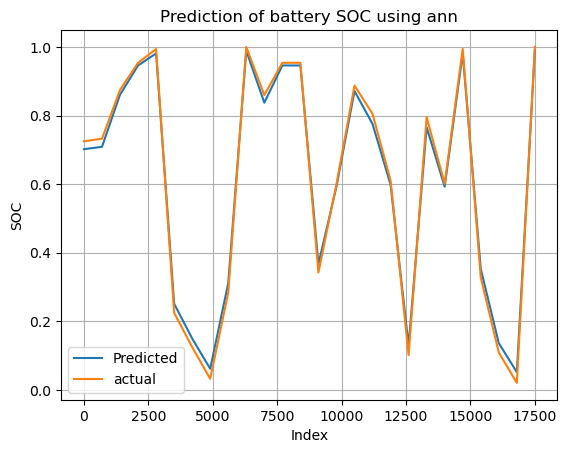

In [238]:
sns.lineplot(data=combined_dataframe[::700],x=combined_dataframe.index[::700],y=0,label="Predicted")
sns.lineplot(data=combined_dataframe[::700],x=combined_dataframe.index[::700],y="SOC",label="actual")
plt.title("Prediction of battery SOC using ann")
plt.xlabel("Index")
plt.ylabel("SOC")
plt.grid(True)

In [254]:
X_test.head(2)

,Time,Voltage,Current,Ah,Power,Wh,Battery_Temp_degC,Ambient_Temp_degC,Cycle_Label,Test_Cell
38268,0.434757,0.728039,0.000004,0.274974,0.002206,0.336026,0.988381,1.0,0.0,0.0
48303,0.548769,0.649044,0.000004,0.421207,0.003602,0.481744,0.974081,1.0,0.0,0.0


In [258]:
df.head()

,Time,Voltage,Current,Ah,SOC,Power,Wh,Battery_Temp_degC,Ambient_Temp_degC,Cycle_Label,Test_Cell
0,0.000000,0.834750,0.047765,0.04617,0.95383,0.046265,0.049774,0.498059,0.5,1.0,1.0
1,0.000011,0.834429,0.047765,0.04617,0.95383,0.046265,0.049774,0.498114,0.5,1.0,1.0
2,0.000023,0.834428,0.047765,0.04617,0.95383,0.046265,0.049774,0.498222,0.5,1.0,1.0
3,0.000034,0.834427,0.047765,0.04617,0.95383,0.046265,0.049774,0.498329,0.5,1.0,1.0
4,0.000045,0.834426,0.047765,0.04617,0.95383,0.046265,0.049774,0.498437,0.5,1.0,1.0


In [349]:
X_train

,Time,Voltage,Current,Ah,Power,Wh,Battery_Temp_degC,Ambient_Temp_degC,Cycle_Label,Test_Cell
78440,0.891169,0.329636,0.000004,0.860412,0.009245,0.887864,0.994781,1.0,0.0,0.0
30803,0.349944,0.795454,0.000004,0.166178,0.001015,0.224215,0.962980,1.0,0.0,0.0
64904,0.737380,0.503102,0.000004,0.663147,0.006180,0.712086,0.979449,1.0,0.0,0.0
87531,0.994456,0.052163,0.000004,0.992896,0.014147,0.994838,0.983246,1.0,0.0,0.0
59142,0.671916,0.553974,0.000004,0.579173,0.005281,0.633819,0.978533,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
6265,0.071179,0.883129,0.112934,0.024707,0.110122,0.026586,0.499650,0.5,1.0,1.0
54886,0.623561,0.594984,0.000002,0.517149,0.004555,0.574853,0.975424,1.0,0.0,0.0
76820,0.872763,0.357318,0.000004,0.836791,0.008756,0.867612,0.970037,1.0,0.0,0.0
860,0.009771,0.834407,0.047765,0.046170,0.046265,0.049774,0.491282,0.5,1.0,1.0


In [ ]:
df_3